In [47]:
import seaborn as sns
import matplotlib
import pandas as pd
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out, display_confusion_matrix
from common.clustering import *
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize
from sklearn.decomposition import PCA

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Constants and settings

In [48]:
columns_used_for_clustering = ["User_Score", "Critic_Score", "EU_Sales", "NA_Sales", "JP_Sales", "Year_of_Release"]
categorical_columns = ["Platform", "Genre", "Rating"]

### Load and prepare dataset
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [49]:
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})

standardize(data, columns_used_for_clustering, columns_stats)

### Outliers detection

In [50]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

## Clustering - 2 clusters
Here we perform clustering for the number of clusters equal to 2 - this is the number of clusters that gave us
the best results in the above analysis.

In [51]:
number_of_clusters = 2
data_without_outliers = drop_outliers_from_dataset(data, outliers)
clustered_data = k_means_multiple_dim_clustering(data_without_outliers, columns_used_for_clustering, number_of_clusters)
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

print("Cluster 0 count: {}".format(clustered_data[clustered_data["cluster"] == 0].shape[0]))
print("Cluster 1 count: {}".format(clustered_data[clustered_data["cluster"] == 1].shape[0]))

Cluster 0 count: 5767
Cluster 1 count: 4476


### Clustering results visualisation

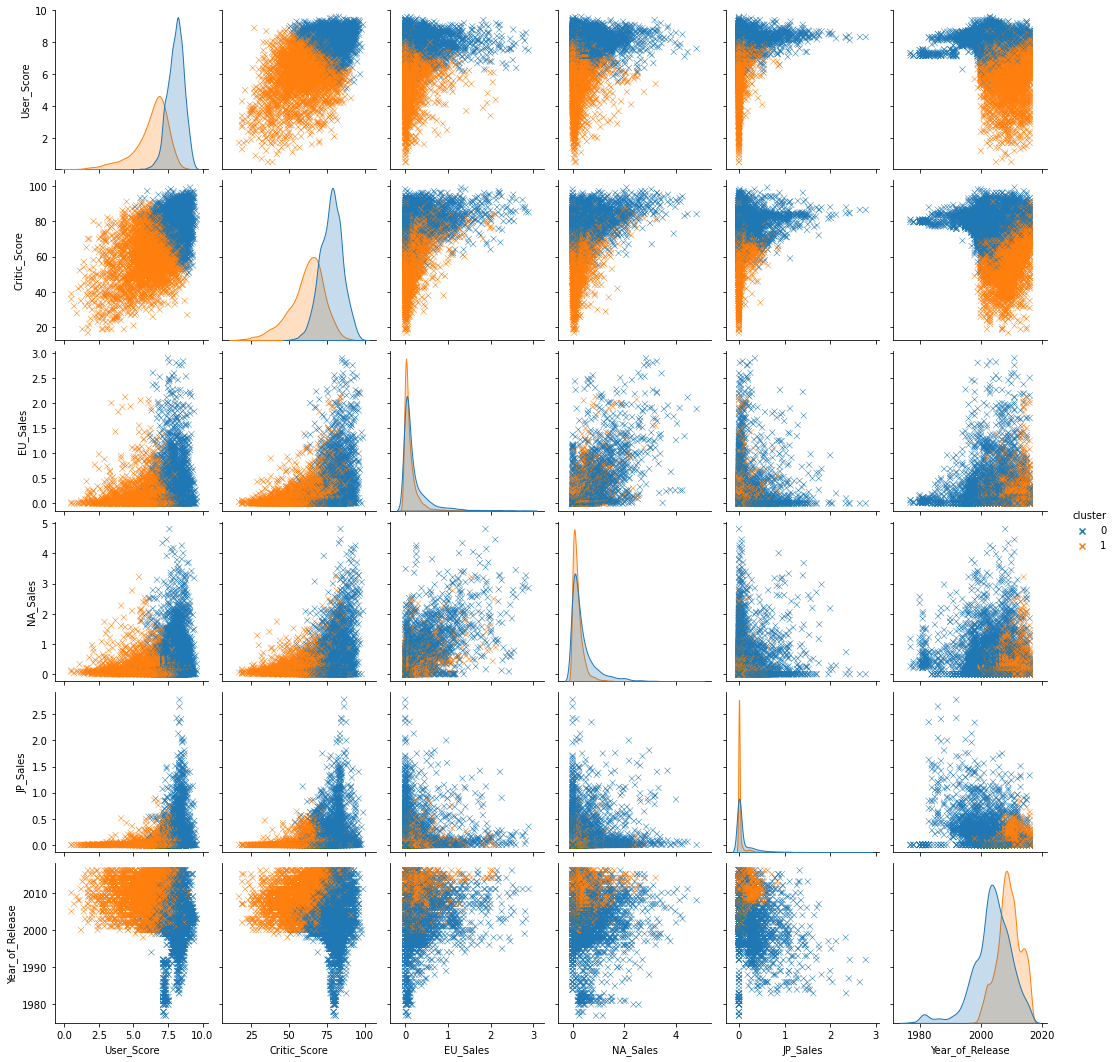

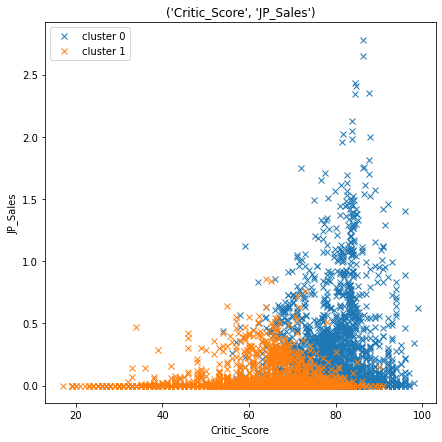

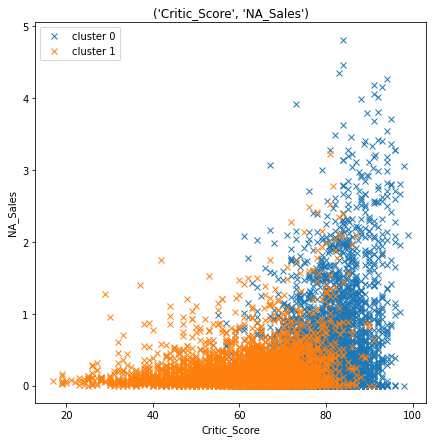

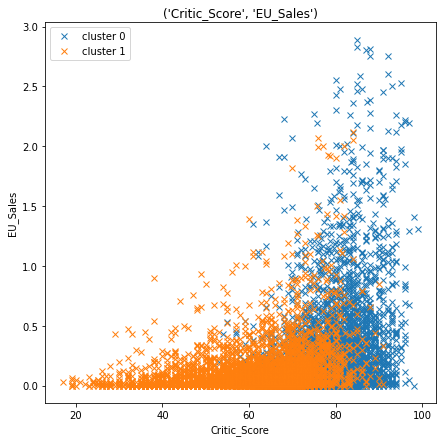

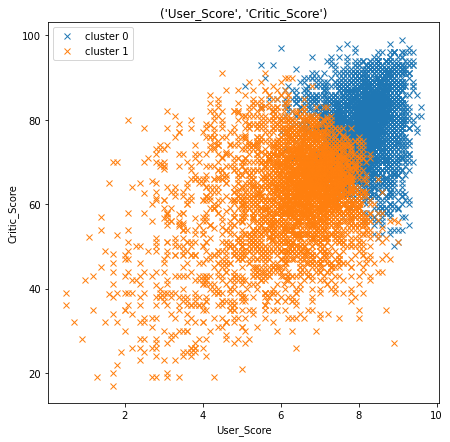

In [52]:
sns.pairplot(data=clustered_data, hue="cluster", markers=['x', 'x'])
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "JP_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_clusters(clustered_data, ("User_Score", "Critic_Score"))

### Clustering results visualisation using PCA

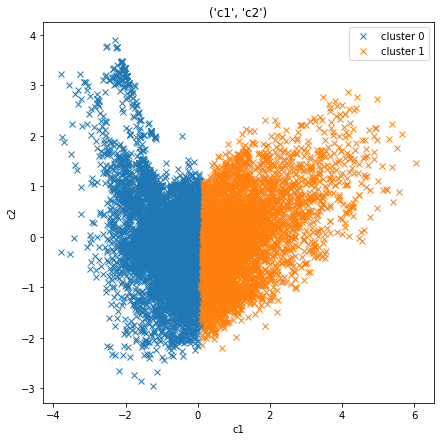

In [53]:
standardize(clustered_data, columns_used_for_clustering, columns_stats)
pca = PCA(n_components=2).fit(clustered_data.filter(columns_used_for_clustering))
reduced = pd.DataFrame(pca.transform(clustered_data.filter(columns_used_for_clustering)), columns=["c1", "c2"], index=clustered_data.index)
reduced.insert(2, "cluster", clustered_data["cluster"])
plot_2d_data_with_clusters(reduced, ("c1", "c2"))
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Clusters analysis - variables distributions for each cluster

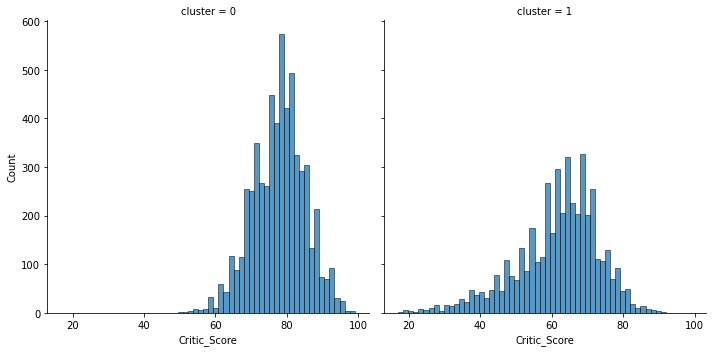

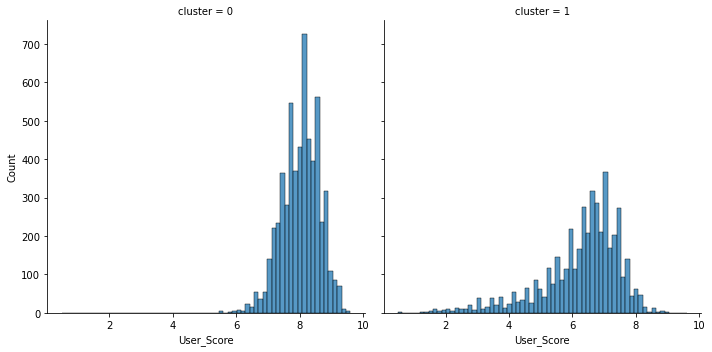

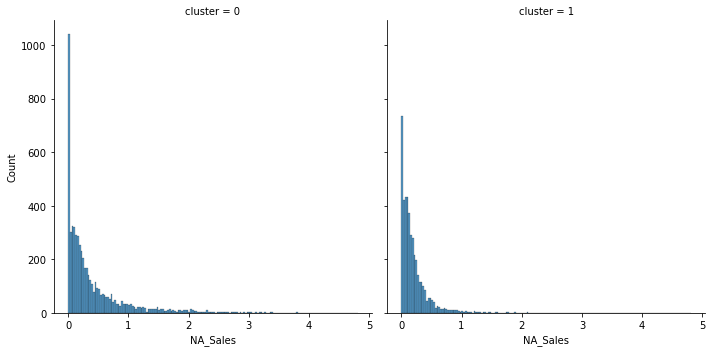

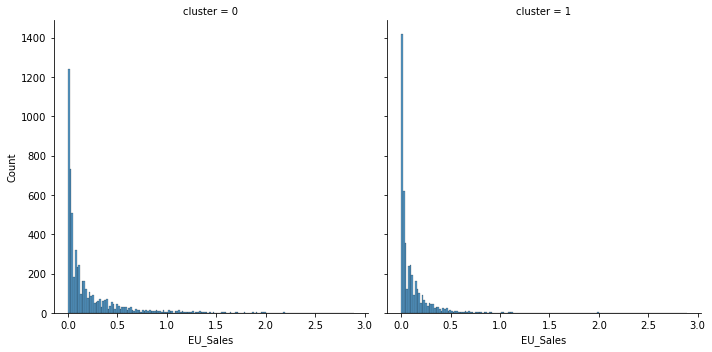

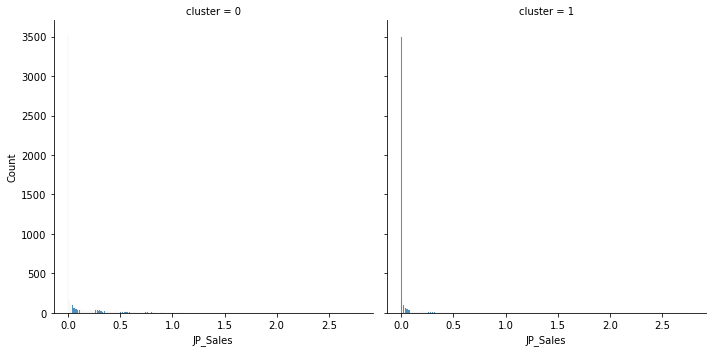

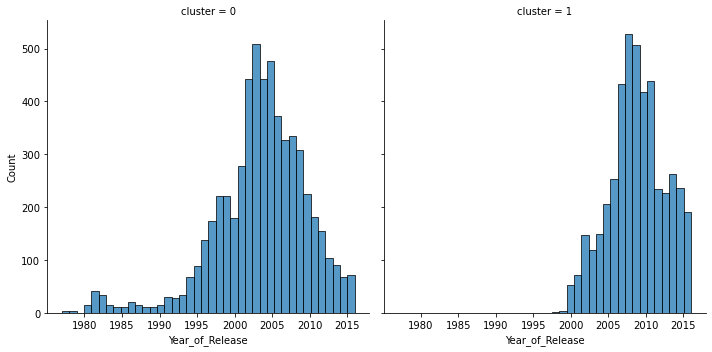

In [54]:
sns.displot(clustered_data, x="Critic_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="User_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="NA_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="EU_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="JP_Sales", col="cluster", multiple="dodge")

years = len(range(np.int32(clustered_data["Year_of_Release"].min()), np.int32(clustered_data["Year_of_Release"].max()) + 1))
sns.displot(clustered_data, bins=years, x="Year_of_Release", col="cluster", multiple="dodge")

### Clusters analysis - variables means for each cluster

         User_Score  Critic_Score  EU_Sales  NA_Sales  JP_Sales  \
cluster                                                           
0          8.037224     77.744859  0.220903  0.419426  0.117663   
1          6.272274     61.633132  0.116231  0.206472  0.026430   

         Year_of_Release  
cluster                   
0            2003.653373  
1            2009.095174  


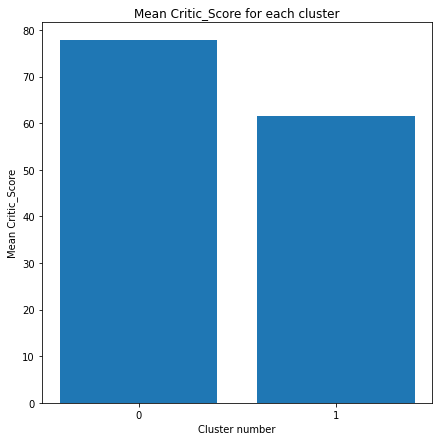

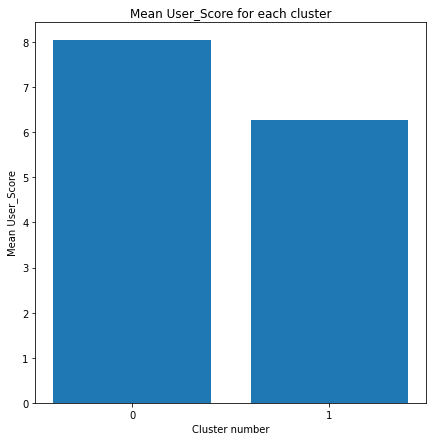

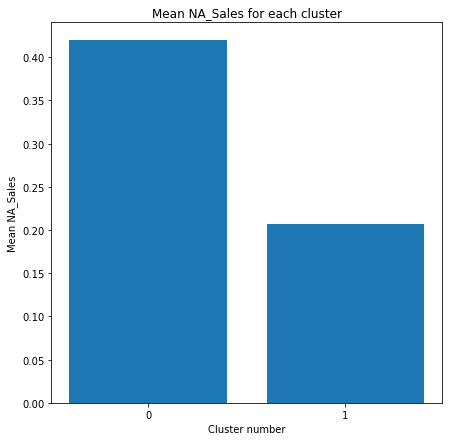

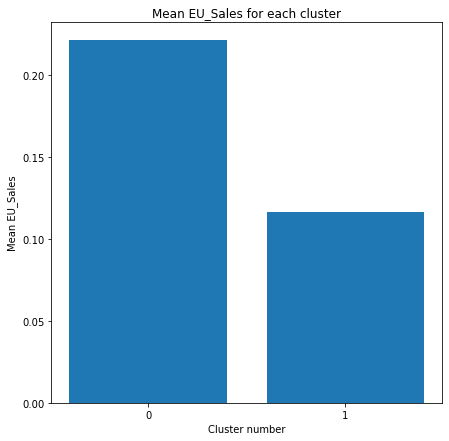

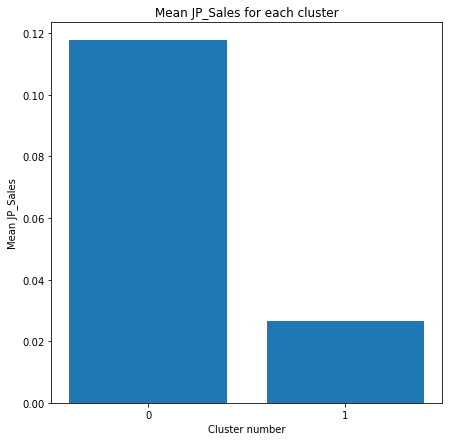

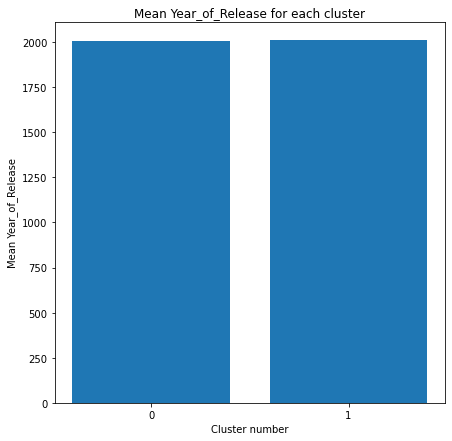

In [55]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Critic_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "User_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "NA_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "EU_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "JP_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Year_of_Release")

### Clusters analysis - categorical variables

<AxesSubplot:xlabel='counts', ylabel='Rating'>

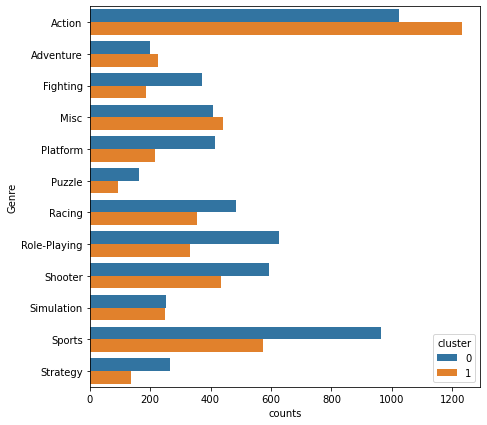

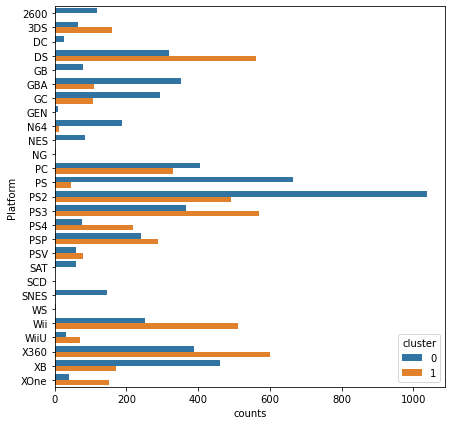

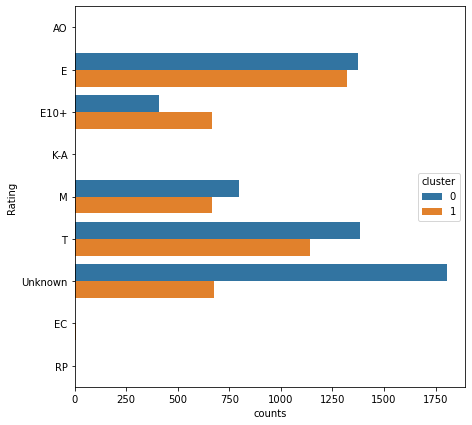

In [56]:
# genres
grouped_by_genre = clustered_data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h')

# platforms
grouped_by_platform = clustered_data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h')

# ratings
grouped_by_platform = clustered_data.groupby(["cluster", "Rating"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Rating", hue="cluster", data=grouped_by_platform, orient='h')

### Classification to clusters
Here we compare results acquired using various classification method on a simple problem -
classification to clusters.

Performing KNN classification - leave one out method
Score: 0.9816460021478083
Performing decision tree classification - leave one out method
Score: 0.9749096944254613


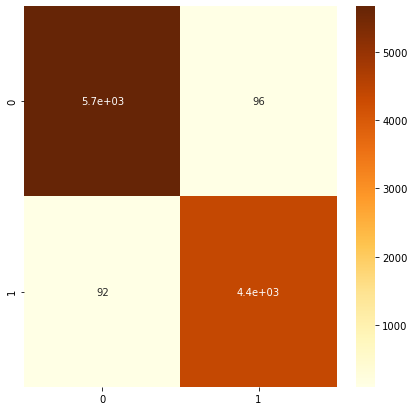

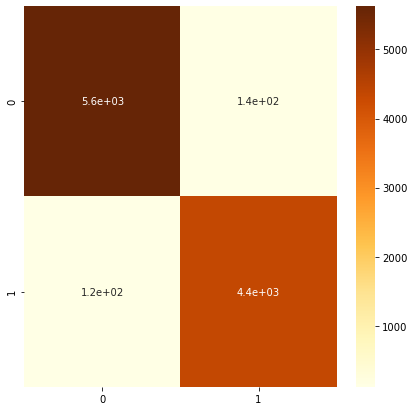

In [57]:
# prepare dataset
standardize(clustered_data, columns_used_for_clustering, columns_stats)
clustered_data = clustered_data.drop(categorical_columns, axis = 1)

# KNN classification
print("Performing KNN classification - leave one out method")
classification_quality, confusion_matrix = k_neighbours_leave_one_out(clustered_data, "cluster", 3)
print("Score: {}".format(classification_quality))
display_confusion_matrix(confusion_matrix)

# Decision tree classification
print("Performing decision tree classification - leave one out method")
classification_quality, confusion_matrix = decision_tree_leave_one_out(clustered_data, "cluster")
print("Score: {}".format(classification_quality))
display_confusion_matrix(confusion_matrix)
